# This is the notebook for cell filtering and lumen distance calculations

## Cell annotation, filtering and lumen distance calculations

In [2]:
import pandas as pd
import numpy as np
import tifffile
import dask.array as da
from dask.array.image import imread
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
import copy
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

class SamplePaths:
    def __init__(self, sample):
        self.sample = sample
        self.sample_final_name = sample_list_final[sample_list.index(sample)]
        self.image_path = image_path_list[sample_list.index(sample)]

        #self.segmentation_mask_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/segmentation/cellpose_lunaphore/{sample}_clahe.ome_cp_masks.tif'
        self.reannotated_regions_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/{sample}_regions.tif'
        self.reannotated_endocardium_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/{sample}_endocardium.tif'
        #self.injury_mask_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_injury.tif'
        self.markers_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/marker_files/AF_corrected/{sample}_markers.csv'
        self.markers = pd.read_csv(self.markers_path)

sample_list = ["Control_12", "Control_13", "Control_14", "4h_96", "4h_97", "24h_83", "24h_86", "48h_76", "48h_79"]

sample_matching = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/sample_name_matching.csv')
sample_list_final = [sample_matching.loc[sample_matching['sample_kb'] == sample, 'sample_final'].values[0] for sample in sample_list]
image_path_list = [sample_matching.loc[sample_matching['sample_kb'] == sample, 'image_path'].values[0] for sample in sample_list]
region_matching = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/region_matching.csv')

In [13]:
cell_data = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels.csv') # Pixie output - file on Synapse

lumen_distance_binsize = 80 # in pixels
minimum_cell_size = 120 # exact value in micrometers as used in Molecular Cartography data processing 200 * 0.138 / 0.23 = 120 (200 px * 0.138 um/px (MC pixel size) / 0.23 um/px (COMET PA pixel size)= 120 um)
maximum_cell_size = 120000 # exact value in micrometers as used in Molecular Cartography data processing


In [14]:
cell_data['timepoint'] = cell_data['fov'].str.split('_').str[0] # adds timepont column

# initialize values for new columns
cell_data['region'] = -1
cell_data['region_name'] = 'unknown'

cell_data['refined_cell_type'] = 'unknown'
cell_data['final_cell_type'] = 'unknown'

cell_data['endocardial_annotation'] = False
cell_data['exclude_annotation'] = False
cell_data['artefact'] = False

cell_data['distance_from_lumen'] = -1
cell_data['lumen_bin'] = -1

cell_data['size_filter'] = False

In [15]:
for sample in sample_list:
    sample_paths = SamplePaths(sample)
    print(sample_paths.reannotated_regions_path)
    reannotated_regions = tifffile.imread(sample_paths.reannotated_regions_path)
    cell_data.loc[cell_data['fov'] == sample, 'region'] = reannotated_regions[cell_data.loc[cell_data['fov'] == sample, 'Y_centroid'].astype(int), cell_data.loc[cell_data['fov'] == sample, 'X_centroid'].astype(int)]

    distance_from_lumen = distance_transform_edt(reannotated_regions != 1)
    cell_data.loc[cell_data['fov'] == sample, 'distance_from_lumen'] = distance_from_lumen[cell_data.loc[cell_data['fov'] == sample, 'Y_centroid'].astype(int), cell_data.loc[cell_data['fov'] == sample, 'X_centroid'].astype(int)]

    reannotated_endocardium = tifffile.imread(sample_paths.reannotated_endocardium_path)
    cell_data.loc[cell_data['fov'] == sample, 'endocardial_annotation'] = reannotated_endocardium[cell_data.loc[cell_data['fov'] == sample, 'Y_centroid'].astype(int), cell_data.loc[cell_data['fov'] == sample, 'X_centroid'].astype(int)]

/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/Control_12_regions.tif


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_16714/2575622954.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[9483.96842045 9469.18581505 9445.49082896 ... 6333.97521309 6341.02554797
 6359.60887162]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cell_data.loc[cell_data['fov'] == sample, 'distance_from_lumen'] = distance_from_lumen[cell_data.loc[cell_data['fov'] == sample, 'Y_centroid'].astype(int), cell_data.loc[cell_data['fov'] == sample, 'X_centroid'].astype(int)]
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_16714/2575622954.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  cell_data.loc[cell_data['fov'] == sample, 'endocardial_annotation'] = reannotated_endo

/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/Control_13_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/Control_14_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/4h_96_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/4h_97_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/24h_83_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/24h_86_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/48h_76_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/48h_79_regions.tif


In [23]:
cell_data['region_name'] = cell_data['region'].map(region_matching.set_index('region_id')['region_name']) # match region names to region ids

cell_data['refined_cell_type'] = cell_data['cell_meta_cluster']
cell_data.loc[(cell_data['endocardial_annotation']>0) & (cell_data['cell_meta_cluster'] == 'Endothelial cells'), 'refined_cell_type'] = 'Endocardial cells' # all cells is in the endocardial annotation and classified as "Endothelial cells", are renamed to "Endocardial cells" in the "refined_cell_type" column

max_distance = cell_data['distance_from_lumen'].max()
next_multiple_of_80 = (np.ceil(max_distance / lumen_distance_binsize) * lumen_distance_binsize) # get maximum lumen bin value possible
bin_edges = np.arange(0, next_multiple_of_80 + lumen_distance_binsize, lumen_distance_binsize)
cell_data['lumen_bin'] = pd.cut(cell_data['distance_from_lumen'], bins=bin_edges, labels=range(1, len(bin_edges))) # assign lumen bin based on lumen_distance_binsize

cell_data.loc[cell_data.region_name.isin(['background', 'lumen', 'ignore']), 'exclude_annotation'] = True # if region_name is background, lumen or ignore, cells should be excluded]
cell_data.loc[cell_data.cell_meta_cluster.isin(['out_of_mask', 'background']), 'exclude_annotation'] = True

cell_data['size_filter'] = np.logical_or(cell_data['cell_size'] < minimum_cell_size, cell_data['cell_size'] > maximum_cell_size) # exclude cells below min and above max filter

artefacts = cell_data[(cell_data['Eccentricity'] > 0.9) & (cell_data['Solidity'] < 0.9) & (cell_data['cell_size'] < 500)].index.values # exclude cells with high eccentricity, low solidity and small size
artefacts = np.concatenate((artefacts, cell_data[(cell_data['Solidity'] < 0.1)].index.values)) # additionally exclude cells with very low solidity
artefacts = np.unique(artefacts)
cell_data.loc[artefacts, 'artefact'] = True

cell_data['final_cell_type'] = cell_data['refined_cell_type']
cell_data.loc[cell_data['exclude_annotation'], 'final_cell_type'] = 'exclude'
cell_data.loc[cell_data['size_filter'], 'final_cell_type'] = 'exclude'
cell_data.loc[cell_data['artefact'], 'final_cell_type'] = 'exclude'
cell_data['distance_from_lumen'] = cell_data['distance_from_lumen'].round(2)

cell_data.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_final.csv', index=False)

### Create masks from lumen bin distances

In [ ]:
cell_data = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_final.csv')

lumen_distance_binsize = 80 # needs to be the same as when creating the cell_table_final.csv file

max_distance = cell_data['distance_from_lumen'].max()
next_multiple_of_80 = (np.ceil(max_distance / lumen_distance_binsize) * lumen_distance_binsize) # get maximum lumen bin value possible
bin_edges = np.arange(0, next_multiple_of_80 + lumen_distance_binsize, lumen_distance_binsize)

sample_list = ["Control_12", "Control_13", "Control_14", "4h_96", "4h_97", "24h_83", "24h_86", "48h_76", "48h_79"]

sample_matching = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/sample_name_matching.csv')
sample_list_final = [sample_matching.loc[sample_matching['sample_kb'] == sample, 'sample_final'].values[0] for sample in sample_list]

for sample in sample_list:
    sample_paths = SamplePaths(sample)
    print(sample_paths.reannotated_regions_path)
    reannotated_regions = tifffile.imread(sample_paths.reannotated_regions_path)

    distance_from_lumen = distance_transform_edt(reannotated_regions != 1)
    lumen_bins = np.digitize(distance_from_lumen, bin_edges, right=True).astype(np.uint8)
    # save lumen_bins
    lumen_bins_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/lumen_expanded_masks/{sample}_lumen_layers.tif'
    tifffile.imwrite(lumen_bins_path, lumen_bins)

/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/Control_12_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/Control_13_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/Control_14_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/4h_96_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/4h_97_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/24h_83_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/24h_86_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/48h_76_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/r

### Prepare data for plots relating to distance from the lumen

In [4]:
# drop columns X_centroid, Y_centroid, region, region_name, refined_cell_type, endocardial_annotation, exclude_annotation, artefact, size_filter
cell_data_subset = cell_data[cell_data['lumen_bin'].isin([1, 2, 3, 4])]
cell_data_subset = cell_data_subset.drop(columns=['X_centroid', 'Y_centroid', 'region', 'region_name', 'refined_cell_type', 'endocardial_annotation', 'exclude_annotation', 'artefact', 'size_filter', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'cell_meta_cluster'])

# in cell_data_subset, per lumen bin get number of mono macro cells
cell_data_subset_mono = cell_data_subset[cell_data_subset['final_cell_type'] == 'Mono / Macros Ccr2+']
cell_data_subset_mono = cell_data_subset_mono.groupby(['fov', 'lumen_bin']).size().reset_index(name='mono_count')
cell_data_subset_all = cell_data_subset.groupby(['fov', 'lumen_bin']).size().reset_index(name='total_count')

cell_data_subset_merged = pd.merge(cell_data_subset_all, cell_data_subset_mono, on=['fov', 'lumen_bin'], how='left')

cell_data_subset_merged['mono_percentage'] = cell_data_subset_merged['mono_count'] / cell_data_subset_merged['total_count']

cell_data_subset_merged['timepoint'] = cell_data_subset_merged['fov'].str.split('_').str[0]

cell_data_subset_merged['lumen_bin'] = cell_data_subset_merged['lumen_bin'].astype(int)

cell_data_subset_endothelial = cell_data_subset[cell_data_subset['final_cell_type'] == 'Endothelial cells']
cell_data_subset_endothelial = cell_data_subset_endothelial.groupby(['fov', 'lumen_bin']).size().reset_index(name='endothelial_count')

cell_data_subset_endocardial = cell_data_subset[cell_data_subset['final_cell_type'] == 'Endocardial cells']
cell_data_subset_endocardial = cell_data_subset_endocardial.groupby(['fov', 'lumen_bin']).size().reset_index(name='endocardial_count')

cell_data_subset_merged = pd.merge(cell_data_subset_merged, cell_data_subset_endothelial, on=['fov', 'lumen_bin'], how='left')
cell_data_subset_merged['endothelial_percentage'] = cell_data_subset_merged['endothelial_count'] / cell_data_subset_merged['total_count']

cell_data_subset_merged = pd.merge(cell_data_subset_merged, cell_data_subset_endocardial, on=['fov', 'lumen_bin'], how='left')
cell_data_subset_merged['endocardial_percentage'] = cell_data_subset_merged['endocardial_count'] / cell_data_subset_merged['total_count']

cell_data_subset_merged.fillna(0, inplace=True)

cell_data_subset_merged['area_px'] = -1
for sample in cell_data_subset_merged.fov.unique():
    sample_paths = SamplePaths(sample)
    lumen_layers = tifffile.imread(f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/lumen_expanded_masks/{sample}_lumen_layers.tif')

    # based on region_name in region_matching, get area in pixels
    for lumen_bin in cell_data_subset_merged.lumen_bin.unique():
        cell_data_subset_merged.loc[(cell_data_subset_merged['fov'] == sample) & (cell_data_subset_merged['lumen_bin'] == lumen_bin), 'area_px'] = np.sum(lumen_layers == lumen_bin)

cell_data_subset_merged['area_um2'] = cell_data_subset_merged['area_px'] * 0.23 * 0.23 # convert area from pixels to micrometers
cell_data_subset_merged['mono_per_um2'] = cell_data_subset_merged['mono_count'] / cell_data_subset_merged['area_um2']
cell_data_subset_merged['mono_per_mm2'] = cell_data_subset_merged['mono_per_um2'] * 1000000

cell_data_subset_merged['endothelial_per_um2'] = cell_data_subset_merged['endothelial_count'] / cell_data_subset_merged['area_um2']
cell_data_subset_merged['endothelial_per_mm2'] = cell_data_subset_merged['endothelial_per_um2'] * 1000000

cell_data_subset_merged['endocardial_per_um2'] = cell_data_subset_merged['endocardial_count'] / cell_data_subset_merged['area_um2']
cell_data_subset_merged['endocardial_per_mm2'] = cell_data_subset_merged['endocardial_per_um2'] * 1000000

In [6]:
cell_data_subset_merged.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_final_lumen_bins_plots.csv', index=False)


In [7]:
df = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_final_lumen_bins_plots.csv')
# Calculate mean and standard deviation or standard error for each feature per lumen bin and timepoint
df_grouped = df.groupby(['lumen_bin', 'timepoint']).agg(
    endothelial_mean=('endothelial_percentage', 'mean'),
    endothelial_std=('endothelial_percentage', 'std'),
    endocardial_mean=('endocardial_percentage', 'mean'),
    endocardial_std=('endocardial_percentage', 'std'),
    mono_mean=('mono_percentage', 'mean'),
    mono_std=('mono_percentage', 'std')
).reset_index()

# Optional: If the number of samples varies, calculate standard error (std / sqrt(n))
df_grouped['endothelial_se'] = df_grouped['endothelial_std'] / np.sqrt(2)  # Assuming 2-3 FOVs, adjust if needed
df_grouped['endocardial_se'] = df_grouped['endocardial_std'] / np.sqrt(2)
df_grouped['mono_se'] = df_grouped['mono_std'] / np.sqrt(2)

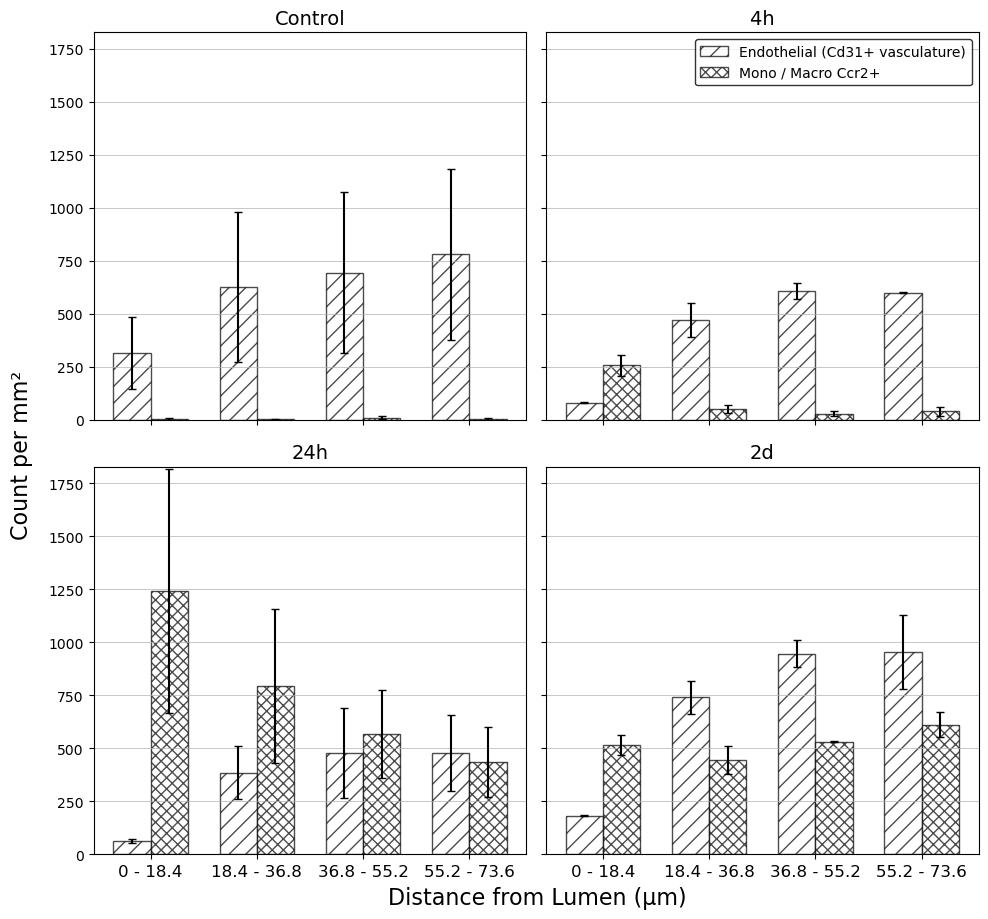

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Ensure timepoints are ordered as Control, 4h, 24h, 2d
timepoint_order = ['Control', '4h', '24h', '2d']

# Calculate mean and SE of count_per_mm2
cell_data_subset_merged = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_final_lumen_bins_plots.csv')
grouped_data = cell_data_subset_merged.groupby(['lumen_bin', 'timepoint']).agg(
    endothelial_mean=('endothelial_per_mm2', 'mean'),
    endothelial_std=('endothelial_per_mm2', 'std'),
    endocardial_mean=('endocardial_per_mm2', 'mean'),
    endocardial_std=('endocardial_per_mm2', 'std'),
    mono_mean=('mono_per_mm2', 'mean'),
    mono_std=('mono_per_mm2', 'std')
).reset_index()

# Optional: If the number of samples varies, calculate standard error (std / sqrt(n))
grouped_data['endothelial_se'] = grouped_data['endothelial_std'] / np.sqrt(2)  # Assuming 2-3 FOVs, adjust if needed
grouped_data['endocardial_se'] = grouped_data['endocardial_std'] / np.sqrt(2)
grouped_data['mono_se'] = grouped_data['mono_std'] / np.sqrt(2)

grouped_data['timepoint'] = grouped_data['timepoint'].replace('48h', '2d')

# Number of unique lumen bins
n_bins = len(grouped_data['lumen_bin'].unique())

# Set width of bars
bar_width = 0.35  # Adjust width to better fit the hatching

# Create subplots in a 2x2 grid with a white background
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharex=True, sharey=True, facecolor='white')

# Flatten axes for easier indexing
axes = axes.flatten()

# List of features and corresponding hatches
features = ['endothelial_mean', 'mono_mean']
errors = ['endothelial_se', 'mono_se']
hatches = ['//', 'xxx']  # Denser hatch for Mono
labels = ['Endothelial (Cd31+ vasculature)', 'Mono / Macro Ccr2+']

# Timepoints in specified order
timepoints_order = ['Control', '4h', '24h', '2d']

# Loop over the timepoints and create subplots
for i, timepoint in enumerate(timepoints_order):
    # Filter the data for the current timepoint
    df_timepoint = grouped_data[grouped_data['timepoint'] == timepoint]
    
    # Loop over the features
    for j, feature in enumerate(features):
        # Shift positions for each feature
        offset = (j - 0.5) * bar_width  # Shift each feature by its index
        
        # Plot the bars with error bars
        axes[i].bar(np.arange(n_bins) + offset, 
                     df_timepoint[feature], 
                     bar_width, 
                     yerr=df_timepoint[errors[j]], 
                     capsize=3, 
                     hatch=hatches[j],  # Apply hatch pattern
                     alpha=0.7, 
                     color='white',  # Set bar color to white
                     edgecolor='black')  # Set edge color to distinguish bars

    # Set titles for each subplot
    axes[i].set_title(f'{timepoint}', fontsize=14)

# Set x-axis tick labels for all subplots
distance_labels = ['0 - 18.4', '18.4 - 36.8', '36.8 - 55.2', '55.2 - 73.6']
for ax in axes:
    ax.set_xticks(np.arange(n_bins))
    ax.set_xticklabels(distance_labels, rotation=0, fontsize=12)
    ax.grid(True, which='both', axis='y', linestyle='-', linewidth=0.5, zorder=1)  # Add grid lines for y-axis

# Set same y-axis limits based on the data
y_min = 0  # Set a minimum y limit
y_max = grouped_data[features].max().max() + grouped_data[errors].max().max() + 10  # Set a max limit based on your data
for ax in axes:
    ax.set_ylim(y_min, y_max)

# Create a global legend for the upper right subplot including both features
handles = [
    plt.Rectangle((0, 0), 1, 1, hatch=hatches[0], alpha=0.7, edgecolor='black', facecolor='none'),  # Endothelial
    plt.Rectangle((0, 0), 1, 1, hatch=hatches[1], alpha=0.7, edgecolor='black', facecolor='none')   # Mono
]
legend = axes[1].legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1), frameon=True, edgecolor='black')

# Set white background for the legend
legend.get_frame().set_facecolor('white')

# Create a global y-axis title closer to the subplots
fig.text(0.09, 0.54, 'Count per mm²', ha='center', va='center', rotation='vertical', fontsize=16)

# Create a global x-axis title closer to the subplots
fig.text(0.52, 0.09, 'Distance from Lumen (µm)', ha='center', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0.1, 0.1, 0.9, 1])  # Make room for the legends and titles

# Save plot as svg and png with tight bounding box
plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/figures_quantification/distance_from_lumen_areanorm.svg', format='svg', bbox_inches='tight')
plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/figures_quantification/distance_from_lumen_areanorm.png', dpi=300, bbox_inches='tight')

plt.show()

### Image showing lumen bins and cell types

In [13]:
# for sample 24h_83, get the cell type information for each cell, and read in the reannotated regions, and lumen_bin
cell_data = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_final.csv')
sample = '24h_83'
sample_paths = SamplePaths(sample)
cell_data_subset = cell_data[cell_data['fov'] == sample]

reannotated_regions = tifffile.imread(sample_paths.reannotated_regions_path)
lumen_bins = tifffile.imread(f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/lumen_expanded_masks/{sample}_lumen_layers.tif')

import zarr
import dask.array
store = tifffile.imread(sample_paths.image_path, aszarr=True)
cache = zarr.LRUStoreCache(store, max_size=2**30)
zobj = zarr.open(cache, mode='r')
data = [
    zobj[int(dataset['path'])]
    for dataset in zobj.attrs['multiscales'][0]['datasets']
]
data = [dask.array.from_zarr(z) for z in data]
n_channels = data[0].shape[0]
for z in data:
    print(z)

dask.array<from-zarr, shape=(18, 28381, 30238), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
dask.array<from-zarr, shape=(18, 14191, 15119), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
dask.array<from-zarr, shape=(18, 7096, 7560), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
dask.array<from-zarr, shape=(18, 3548, 3780), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
dask.array<from-zarr, shape=(18, 1774, 1890), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
dask.array<from-zarr, shape=(18, 887, 945), dtype=uint16, chunksize=(1, 887, 945), chunktype=numpy.ndarray>


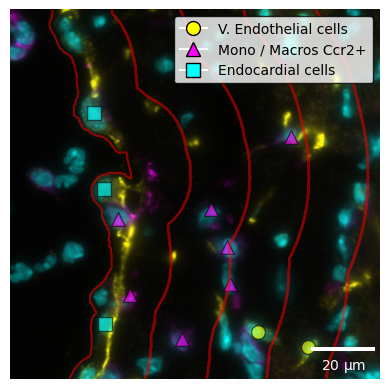

In [24]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
from skimage import segmentation

# Define the region of interest
roi_coords = [18065, 18565, 20009, 20509]

# Extract the region of interest for each channel
channel_0 = data[0][0, roi_coords[0]:roi_coords[1], roi_coords[2]:roi_coords[3]]  # Cyan
channel_1 = data[0][7, roi_coords[0]:roi_coords[1], roi_coords[2]:roi_coords[3]]  # Magenta
channel_2 = data[0][5, roi_coords[0]:roi_coords[1], roi_coords[2]:roi_coords[3]]  # Yellow

# Normalize the channels to the range [0, 1]
channel_0 = (channel_0 - channel_0.min()) / (channel_0.max() - channel_0.min())
channel_1 = (channel_1 - channel_1.min()) / (channel_1.max() - channel_1.min())
channel_2 = (channel_2 - channel_2.min()) / (channel_2.max()+3000 - channel_2.min())

# Create RGB components for cyan, magenta, and yellow
cyan = np.dstack((np.zeros_like(channel_0), channel_0, channel_0))  # Cyan: G + B
magenta = np.dstack((channel_1, np.zeros_like(channel_1), channel_1))  # Magenta: R + B
yellow = np.dstack((channel_2, channel_2, np.zeros_like(channel_2)))  # Yellow: R + G

# Combine the RGB components
rgb_image = np.clip(cyan + magenta + yellow, 0, 1)

# Plot the RGB image
plt.imshow(rgb_image)

# Overlay the reannotated regions and lumen bins
reannotated_CROP = reannotated_regions[roi_coords[0]:roi_coords[1], roi_coords[2]:roi_coords[3]]
lumen_bins_CROP = lumen_bins[roi_coords[0]:roi_coords[1], roi_coords[2]:roi_coords[3]]

# contours
lumen_boundaries = segmentation.find_boundaries(lumen_bins_CROP, mode='outer')
plt.contour(lumen_boundaries, colors='red', linewidths=1, alpha=0.5)  # Uniform contour intensity

plt.axis('off')

# add white points for all centroids in the crop
centroids = cell_data_subset[(cell_data_subset['X_centroid'] >= roi_coords[2]) & (cell_data_subset['X_centroid'] < roi_coords[3]) & (cell_data_subset['Y_centroid'] >= roi_coords[0]) & (cell_data_subset['Y_centroid'] < roi_coords[1])]
#plt.scatter(centroids['X_centroid'] - roi_coords[2], centroids['Y_centroid'] - roi_coords[0], color='white', marker='.')

# cells that are mono/macrophages should be in magenta, and the size should be bigger, cells that are endothelial should be in yellow also bigger, cells that are endocardial should be in cyan
mono_macrophages = centroids[centroids['final_cell_type'] == 'Mono / Macros Ccr2+']
endothelial = centroids[centroids['final_cell_type'] == 'Endothelial cells']
endocardial = centroids[centroids['final_cell_type'] == 'Endocardial cells']

# the cells should have an outline monos should be squares, endothelial should be circles, endocardial should be triangles, no fill
plt.scatter(mono_macrophages['X_centroid'] - roi_coords[2], mono_macrophages['Y_centroid'] - roi_coords[0], marker='^', s=100, edgecolor='black', color='magenta', alpha=0.6)
plt.scatter(endothelial['X_centroid'] - roi_coords[2], endothelial['Y_centroid'] - roi_coords[0], marker='o', s=100, edgecolor='black', color='yellow', alpha=0.6)
plt.scatter(endocardial['X_centroid'] - roi_coords[2], endocardial['Y_centroid'] - roi_coords[0], marker='s', s=100, edgecolor='black', color='cyan', alpha=0.6)

# Add scale bar (1 pixel is 0.23 µm)
microns_per_pixel = 0.00000023
scalebar = ScaleBar(microns_per_pixel, location='lower right', color='white', box_alpha=0, scale_loc='bottom')
plt.gca().add_artist(scalebar)
plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/figures_quantification/24h_83_region_of_interest_plot_nolegend.svg', format='svg', bbox_inches='tight')
plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/figures_quantification/24h_83_region_of_interest_plot_nolegend.png', dpi=300, bbox_inches='tight')

# add a legend specifying the colors and shapes
handles = [

    plt.Line2D([0], [0], marker='o', color='w', label='V. Endothelial cells', markerfacecolor='yellow', markersize=10, markeredgecolor='black'),
    plt.Line2D([0], [0], marker='^', color='w', label='Mono / Macros Ccr2+', markerfacecolor='magenta', markersize=10, markeredgecolor='black'),
    plt.Line2D([0], [0], marker='s', color='w', label='Endocardial cells', markerfacecolor='cyan', markersize=10, markeredgecolor='black')
]
plt.legend(handles=handles, loc='upper right', fontsize=10, frameon=True, edgecolor='black')

plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/figures_quantification/24h_83_region_of_interest_plot.svg', format='svg', bbox_inches='tight')
plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/figures_quantification/24h_83_region_of_interest_plot.png', dpi=300, bbox_inches='tight')

plt.show()